<a href="https://colab.research.google.com/github/heitorabqg/datascientist/blob/master/PSI5892_MLP_luas_1111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# MLP genérica para solução do problemas das meias luas

Neste exercício vamos treinar uma rede MLP com o algorotimo backpropagation para a solução do problema das meias luas.

In [31]:
import numpy as np
import matplotlib.pyplot as plt

Vamos gerar os dados de treinamento do problema das meias-luas.

In [32]:
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    # total de dados de treinamento
    Nt = NA + NB

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    x1A = rxy * np.cos(a)
    x2A = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((x1A, x2A, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    x1B = rxy * np.cos(a) + r1
    x2B = -rxy * np.sin(a) - r2
    dB = -np.ones((NB, 1))
    pontosB = np.hstack((x1B, x2B, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(x1A, x2A, ".b")
    ax1.plot(x1B, x2B, ".r")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

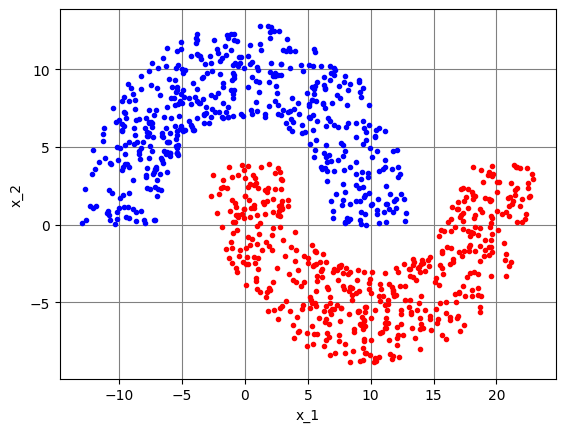

In [33]:
# número de pontos de treinamento da Região A
NA = 500

# número de pontos de treinamento da Região B
NB = 500

# número total de dados de treinamento
Nt = NA + NB

r1 = 10
r3 = 6
r2 = -4

dados_treino = meias_luas(NA, NB, r1, r2, r3)

In [34]:
# organizando os dados para entrada da MLP

# sinal de entrada
x = dados_treino[:, [0, 1]]

# sinal desejado
d = dados_treino[:, [2]]

# Exercício 1

Implemente uma função para treinamento de uma rede MLP genérica usando o algoritmo do gradiente estocástico, considerando a função de ativação $f(x) = \textnormal{tanh}(x)$ com derivada $f'(x) = 1 - \textnormal{tanh}^2(x)$.

Para definir a estrutura da rede, utilize uma entrada chamada `Nn` contendo o número de entradas da rede, seguido do número de neurônios de cada camada. Por exemplo: `Nn = [2, 3, 2, 1]` representa uma rede com duas entradas, duas camadas ocultas com 3 e 2 neurônios, respectivamente e um único neurônio na camada de saída.

Considere a seguinte assinatura para a função:

```python
def redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
       utilize um tensor de mesmas dimensões de W0
    """
```

Após implementação da função para treinamento, treine uma rede para solucionar o problemas das meias luas considerando os dados `x`e `d` criados anteriormente. Faça um gráfico da função custo ao longo das épocas de treinamento.

## Resolução

In [35]:
def redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0=None):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
       utilize um tensor de mesmas dimensões de W00
    """

    # número de mini-batches por época
    Nmb = int(np.floor(Nt / Nb))

    # Número de camadas com neurônios ou camadas da rede sem contar a entrada
    L = len(Nn) - 1

    # Inicialização da matriz W com números aleatórios uniformemente distribuidos usando listas
    # os pesos são colocados em matrizes
    # a matriz inteira entre camadas pode ser acessada por W[j]
    # cada elemento na possição k, l de W[j] pode ser acessado por W[j][k,l]
    # cada matriz pode ter dimensão diferente conforme sua camada e a anterior
    if W0 is None:
        W = [np.random.uniform(-0.5, 0.5, (Nn[j], Nn[j-1] + 1)) for j in range(1, len(Nn))]
    else:
        W = [np.copy(W0[j]) for j in range(len(W0))]

    # Função de ativação tangente hiperbólica (f) e derivada (df)
    f = lambda x: np.tanh(x)
    df = lambda x: 1 - np.tanh(x)**2


    # Vetor para armazenar o MSE
    J_MSE = np.zeros(Ne)

    # Loop de treinamento
    for epoca in range(Ne):
        soma_erro = 0

        # Embaralha dados
        index = np.random.permutation(Nt)
        x = x[index, :]
        d = d[index, :]

        # Loop de Mini-Batch
        for i in range(Nmb):
            # Seleciona o mini-batch
            x_batch = x[i:i+Nb, :]
            d_batch = d[i:i+Nb, :]

            # Inicializa os gradientes
            # cria uma matriz de zeros com o mesmo formato que Wj
            # com W sendo uma lista e Wj uma matriz de pesos entre duas camadas
            grad = [np.zeros_like(Wj) for Wj in W]


            for n in range(len(x_batch)):
                # Cálculo progressivo (Forward Pass)
                # Listas criadas com L+1 posições
                # y[0] é entrada e y[1]... y[L] são as saídas das camadas ocultas e da saída final
                y = [None] * (L + 1)
                # valores da função de ativação
                v = [None] * (L + 1)

                y[0] = x_batch[n, :].reshape(-1, 1)

                for j in range(1, L + 1):
                    # adiciona bias
                    x_j = np.vstack(([1], y[j-1]))
                    v[j] = np.dot(W[j-1], x_j)
                    y[j] = f(v[j])

                # Erro na saída
                e = d_batch[n, :].reshape(-1, 1) - y[L]
                soma_erro += np.mean(e**2)

                # Cálculo regressivo (Backpropagation)

                delta = [None] * (L + 1)

                # Camada de saída j = L
                delta[L] = df(v[L]) * e


                # outras camadas, percorrendo de trás para frente
                for j in range(L-1, 0, -1):
                    # W sem bias
                    W_no_bias = W[j][:, 1:]
                    delta[j] = df(v[j])* np.dot(W_no_bias.T, delta[j+1])  #HA


                for j in range(1, L + 1):
                    # inclui bias
                    x_j = np.vstack(([1], y[j-1]))
                    grad[j-1] += eta * np.dot(delta[j], x_j.T)


            for j in range(1, L + 1):
                W[j-1] += grad[j-1] / Nb


        J_MSE[epoca] = soma_erro / Nt

        #print(f"Epoca {epoca+1}/{Ne} - MSE = {J_MSE[epoca]:.6f}")

    # gráfico da função custo ao longo das épocas de treinamento
    plt.figure(figsize=(7,5))
    plt.plot(10*np.log10(J_MSE), 'b-', linewidth=2)
    plt.title('Função Custo MSE ao longo do Treinamento', fontsize=12)
    plt.xlabel('épocas', fontsize=11)
    plt.ylabel('J_MSE (dB)', fontsize=11)
    plt.show()

    return J_MSE, W


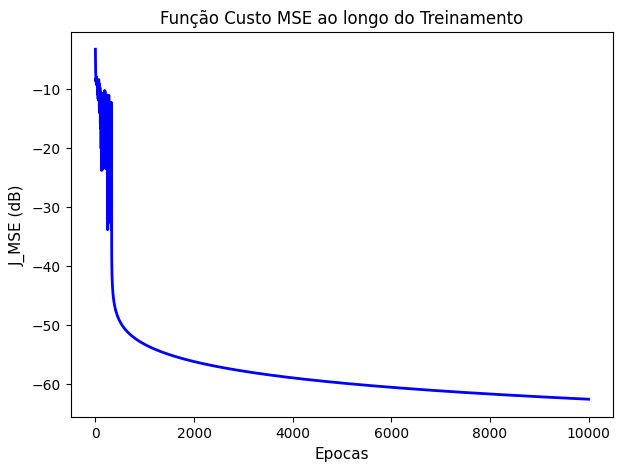

In [43]:
# Treine uma rede para solucionar o problemas das meias luas considerando os dados xe d criados anteriormente.
# Faça um gráfico da função custo ao longo das épocas de treinamento.

Nn = [2, 3, 2, 1]
eta = 0.01

# Nb = 1 para usar no modo estocástico
Nb = 1
Ne = 10000


L = len(Nn) - 1
W0 = [np.random.uniform(-0.5, 0.5, (Nn[j], Nn[j-1] + 1)) for j in range(1, L+1)]



# Treinamento da rede MLP
J_MSE, W_final = redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0)

# Exercício 2

Utilizando os seguintes dados de teste:

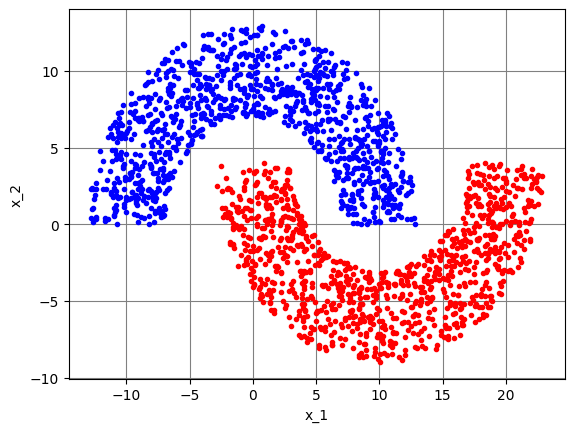

In [36]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

# entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada

# sinal desejado
dteste = dados_teste[:, 2].reshape(-1, 1)

Implemente uma função para teste da rede MLP treinada anteriormente, com a seguinte assinatura:

``` python
def redeMLP_teste(x, d, W, Nn, Nteste):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época (mesmo formato do treinamento)
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    """
```

Em seguida, faça o teste da rede com os dados de teste, apresente a taxa de erro e a curva de separação das duas regiões obtidas com a rede treinada.

## Resolução

In [44]:
import numpy as np

def redeMLP_teste(x, d, W, Nn, Nteste):
    """
    Teste da rede MLP treinada (modo feedforward)

    Entradas:
    ----------
    x : np.ndarray
        Sinal de entrada (Nteste x Nn[0])
    d : np.ndarray
        Sinal desejado (Nteste x Nn[-1])
    W : list[np.ndarray]
        Lista de matrizes de pesos (incluindo bias) da última época
    Nn : list[int]
        Estrutura da rede, ex: [2, 5, 1]
    Nteste : int
        Número de amostras de teste

    Saídas:
    -------
    J_MSE : float
        Erro quadrático médio no teste
    y : np.ndarray
        Saída da rede para cada amostra (Nteste x Nn[-1])
    """

    L = len(Nn) - 1
    # função de ativação
    f = lambda x: np.tanh(x)

    y = np.zeros((Nteste, Nn[-1]))

    soma_erro = 0

    for n in range(Nteste):
        # Forward pass
        yj = x[n, :].reshape(-1, 1)
        for j in range(1, L + 1):
            xj = np.vstack(([1], yj))  # inclui o bias
            vj = np.dot(W[j-1], xj)
            yj = f(vj)
        y[n, :] = yj.T

        # Cálculo do erro quadrático
        e = d[n, :].reshape(-1, 1) - yj
        soma_erro += np.mean(e**2)

    J_MSE = soma_erro / Nteste
    return J_MSE, y



MSE no teste = 0.002156
Taxa de erro no teste = 0.10%


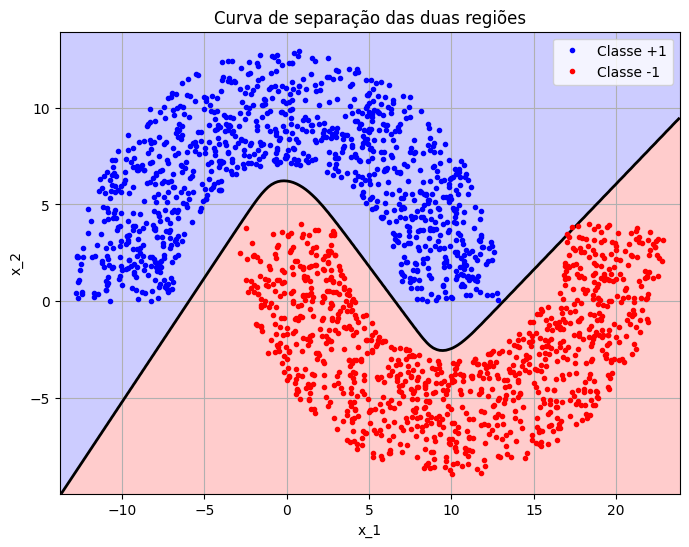

In [45]:
# Teste da rede
J_MSE_teste, yteste = redeMLP_teste(xteste, dteste, W_final, Nn, Nteste)
print(f"\nMSE no teste = {J_MSE_teste:.6f}")

# Classificação teste
yclass = np.sign(yteste)

# Taxa de erro
erros = np.sum(yclass != dteste)
taxa_erro = erros / Nteste * 100
print(f"Taxa de erro no teste = {taxa_erro:.2f}%")

# Curva de separação
x1_grid = np.linspace(np.min(xteste[:,0]) - 1, np.max(xteste[:,0]) + 1, 200)
x2_grid = np.linspace(np.min(xteste[:,1]) - 1, np.max(xteste[:,1]) + 1, 200)
xx1, xx2 = np.meshgrid(x1_grid, x2_grid)

# Criação do grid
Xgrid = np.column_stack((xx1.ravel(), xx2.ravel()))
_, Ygrid = redeMLP_teste(Xgrid, np.zeros((Xgrid.shape[0], 1)), W_final, Nn, Xgrid.shape[0])
Ygrid = Ygrid.reshape(xx1.shape)

# Plot
plt.figure(figsize=(8,6))
plt.contourf(xx1, xx2, Ygrid, levels=[-1, 0, 1], colors=['red', 'blue'], alpha=0.2)
plt.contour(xx1, xx2, Ygrid, levels=[0], colors='k', linewidths=2)

# Dados reais de teste
plt.plot(xteste[dteste[:,0]==1,0], xteste[dteste[:,0]==1,1], '.b', label='Classe +1')
plt.plot(xteste[dteste[:,0]==-1,0], xteste[dteste[:,0]==-1,1], '.r', label='Classe -1')

plt.title('Curva de separação das duas regiões')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.legend()
plt.grid(True)
plt.show()